In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v016.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import tqdm

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch

Loading /ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks/../mre_pinn/__init__.py


True

In [44]:
# load the true wave image
data_root = '../data/BIOQIC'
wave_base = 'four_target_phantom.mat'
wave_file = data_root + '/' + wave_base
wave_data, _ = mre_pinn.data.load_mat_data(wave_file)

# convert to xarray and add metadata
u_true = wave_data['u_ft'].T
u_dims = ['frequency', 'component', 'z', 'x', 'y']
dx = 1 #e-3 # spatial resolution in meters
u_coords = {
    'frequency': np.linspace(50, 100, u_true.shape[0]), # Hz
    'x': np.arange(u_true.shape[3]) * dx,
    'y': np.arange(u_true.shape[4]) * dx,
    'z': np.arange(u_true.shape[2]) * dx,
    'component': ['y', 'x', 'z'],
}
u_true = xr.DataArray(u_true, dims=u_dims, coords=u_coords) * dx
u_true = u_true.transpose('frequency', 'x', 'y', 'z', 'component')

# downsampling
ds = 1
u_true = u_true.coarsen(x=ds, y=ds, z=ds).mean()

freq = 100
z = 0
y = 75

# single frequency 1D
u_true = u_true.sel(frequency=[freq], y=y, z=z, component=['z'])

# single frequency 2D
#u_true = u_true.sel(frequency=[freq], z=0, component=['x', 'y'])

# single frequency 3D
#u_true = u_true.sel(frequency=[freq], component=['x', 'y', 'z'])

# multifrequency 3D
u_true = u_true.sel(component=['x', 'y', 'z'])

print(np.prod(u_true.shape))
u_true

1440000


<xarray.DataArray (frequency: 6, x: 80, y: 100, z: 10, component: 3)>
array([[[[[ 4.41610136e-12+4.15293497e-13j,
            1.80392877e-03-2.21015603e-03j,
            7.43590828e-12+9.91063094e-12j],
          [ 1.31072889e-21-1.55283972e-22j,
            1.77340791e-03-2.24933157e-03j,
            2.72998684e-20+3.60913412e-20j],
          [ 0.00000000e+00+0.00000000e+00j,
            1.73815892e-03-2.29137902e-03j,
            0.00000000e+00+0.00000000e+00j],
          ...,
          [ 0.00000000e+00+0.00000000e+00j,
            1.53102016e-03-2.50421953e-03j,
            0.00000000e+00+0.00000000e+00j],
          [ 1.31146067e-12-2.80054899e-13j,
            1.48959832e-03-2.53624011e-03j,
            1.07067832e-11+1.17379437e-11j],
          [ 0.00000000e+00+0.00000000e+00j,
            1.44979279e-03-2.56093656e-03j,
            0.00000000e+00+0.00000000e+00j]],

...

         [[ 1.20711900e-04+5.54074597e-05j,
           -1.00023484e-04+1.36753538e-04j,
           -1.96984648e-03+6.47758301e-04j],
          [ 1.26588107e-04+2.97468078e-05j,
           -9.95064987e-05+1.46854257e-04j,
           -1.99102903e-03+6.01061728e-04j],
          [ 1.09840310e-04+3.24128881e-05j,
           -9.50972761e-05+1.22089349e-04j,
           -1.91212253e-03+6.23055927e-04j],
          ...,
          [-9.08173401e-05+1.84582541e-04j,
            2.95336889e-05+2.89242094e-05j,
           -1.98020856e-03+5.95482056e-04j],
          [-9.65727975e-05+1.50526975e-04j,
            2.40140120e-05+3.34154881e-05j,
           -1.95558998e-03+6.29691257e-04j],
          [-7.38893222e-05+8.16353244e-05j,
            1.03669066e-05+5.69770862e-05j,
           -1.93945465e-03+6.69014975e-04j]]]]])
Coordinates:
  * frequency  (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x          (x) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 75.0 76.0 77.0 78.0 79.0
  * y          (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 95.0 96.0 97.0 98.0 99.0
  * z          (z) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * component  (component) <U1 'x' 'y' 'z'

In [45]:
# load the true elastogram
elast_base = 'fem_box_ground_truth.npy'
elast_file = data_root + '/' + elast_base

print(f'Loading {elast_file}')
mu_true = np.load(elast_file)
print(mu_true.shape, mu_true.dtype)

# convert to xarray and add metadata
mu_dims = ['frequency', 'z', 'x', 'y']
mu_coords = {
    'frequency': np.linspace(50, 100, mu_true.shape[0]), # Hz
    'x': np.arange(mu_true.shape[2]) * dx / 4 - dx * 3 / 8,
    'y': np.arange(mu_true.shape[3]) * dx / 4 - dx * 3 / 8,
    'z': np.arange(mu_true.shape[1]) * dx,
}
mu_true = xr.DataArray(mu_true, dims=mu_dims, coords=mu_coords) # Pa
mu_true = mu_true.transpose('frequency', 'x', 'y', 'z')

# downsampling
mu_true = mu_true.coarsen(x=4*ds, y=4*ds, z=ds).mean()

# single frequency 1D
#mu_true = mu_true.sel(frequency=[freq], z=0)

# single frequency 2D
#mu_true = mu_true.sel(frequency=[freq], z=0)

mu_true

Loading ../data/BIOQIC/fem_box_ground_truth.npy
(6, 10, 320, 400) complex128


<xarray.DataArray (frequency: 6, x: 80, y: 100, z: 10)>
array([[[[3000.+314.15926536j, 3000.+314.15926536j,
          3000.+314.15926536j, ..., 3000.+314.15926536j,
          3000.+314.15926536j, 3000.+314.15926536j],
         [3000.+314.15926536j, 3000.+314.15926536j,
          3000.+314.15926536j, ..., 3000.+314.15926536j,
          3000.+314.15926536j, 3000.+314.15926536j],
         [3000.+314.15926536j, 3000.+314.15926536j,
          3000.+314.15926536j, ..., 3000.+314.15926536j,
          3000.+314.15926536j, 3000.+314.15926536j],
         ...,
         [3000.+314.15926536j, 3000.+314.15926536j,
          3000.+314.15926536j, ..., 3000.+314.15926536j,
          3000.+314.15926536j, 3000.+314.15926536j],
         [3000.+314.15926536j, 3000.+314.15926536j,
          3000.+314.15926536j, ..., 3000.+314.15926536j,
          3000.+314.15926536j, 3000.+314.15926536j],
         [3000.+314.15926536j, 3000.+314.15926536j,
          3000.+314.15926536j, ..., 3000.+314.15926536j,
          3000.+314.15926536j, 3000.+314.15926536j]],

...

        [[3000.+628.31853072j, 3000.+628.31853072j,
          3000.+628.31853072j, ..., 3000.+628.31853072j,
          3000.+628.31853072j, 3000.+628.31853072j],
         [3000.+628.31853072j, 3000.+628.31853072j,
          3000.+628.31853072j, ..., 3000.+628.31853072j,
          3000.+628.31853072j, 3000.+628.31853072j],
         [3000.+628.31853072j, 3000.+628.31853072j,
          3000.+628.31853072j, ..., 3000.+628.31853072j,
          3000.+628.31853072j, 3000.+628.31853072j],
         ...,
         [3000.+628.31853072j, 3000.+628.31853072j,
          3000.+628.31853072j, ..., 3000.+628.31853072j,
          3000.+628.31853072j, 3000.+628.31853072j],
         [3000.+628.31853072j, 3000.+628.31853072j,
          3000.+628.31853072j, ..., 3000.+628.31853072j,
          3000.+628.31853072j, 3000.+628.31853072j],
         [3000.+628.31853072j, 3000.+628.31853072j,
          3000.+628.31853072j, ..., 3000.+628.31853072j,
          3000.+628.31853072j, 3000.+628.31853072j]]]])
Coordinates:
  * frequency  (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x          (x) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 75.0 76.0 77.0 78.0 79.0
  * y          (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 95.0 96.0 97.0 98.0 99.0
  * z          (z) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0

(6, 80, 100, 10, 3) ['frequency', 'x', 'y', 'z', 'component']
3 2


<IPython.core.display.Javascript object>


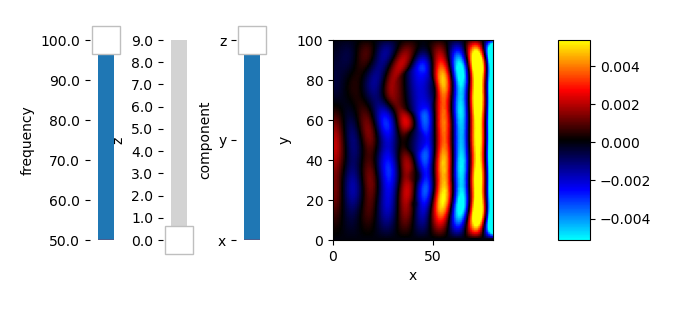

(6, 80, 100, 10, 3) ['frequency', 'x', 'y', 'z', 'component']
4 1


<IPython.core.display.Javascript object>


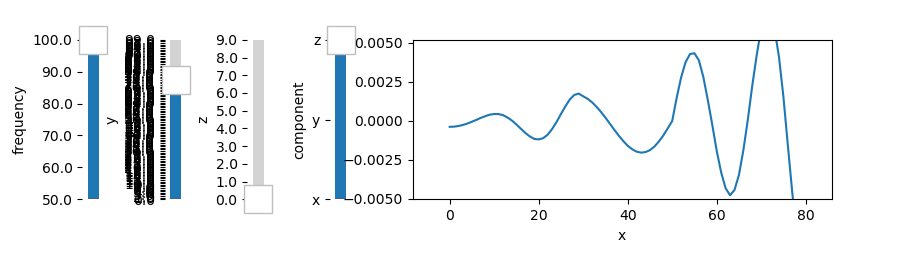

<xarray.DataArray (component: 80)>
array([ 4.41610136e-12, -1.04787094e-04, -2.04990388e-04, -2.96044877e-04,
       -3.71790349e-04, -4.30931033e-04, -4.72687148e-04, -4.91752885e-04,
       -4.86212164e-04, -4.56577247e-04, -4.05259708e-04, -3.37127748e-04,
       -2.49529428e-04, -1.46249465e-04, -3.18903557e-05,  9.13042990e-05,
        2.16997985e-04,  3.43794707e-04,  4.67017489e-04,  5.83272545e-04,
        6.91453793e-04,  7.88870284e-04,  8.72604145e-04,  9.40951292e-04,
        9.92874309e-04,  1.03078108e-03,  1.05591083e-03,  1.06677065e-03,
        1.06406933e-03,  1.05081082e-03,  1.02774298e-03,  9.99955035e-04,
        9.66668701e-04,  9.30045758e-04,  8.92599658e-04,  8.53189114e-04,
        8.16879852e-04,  7.83195461e-04,  7.52254003e-04,  7.24542811e-04,
        6.98169333e-04,  6.76826398e-04,  6.59046767e-04,  6.44588198e-04,
        6.32749170e-04,  6.24177628e-04,  6.20224058e-04,  6.20001932e-04,
        6.22490867e-04,  6.28481988e-04,  6.38611424e-04,  6.5171

In [46]:
%autoreload

# display true wave field, elastogram, and direct inversion result
w_map = mre_pinn.visual.wave_color_map()
w_max = 1e-6
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

e_map = mre_pinn.visual.elast_color_map()
e_max = 25e3
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

L_max = 6e-2
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

Lu_true = mre_pinn.discrete.laplacian(u_true, resolution=dx, dim=1)
Lu_true = xr.DataArray(Lu_true, dims=u_true.dims, coords=u_true.coords)

omega = u_true.frequency.to_numpy().reshape([(-1, 1)[i > 0] for i in range(u_true.ndim)])
mu_u_Lu = mre_pinn.discrete.helmholtz_inversion(u_true, Lu_true, omega)

mre_pinn.visual.NDArrayViewer(u_true.real, x='x', y='y',  dpi=50 / ds, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_true.real, x='x', y=None, dpi=50 / ds, **wave_kws)
#mre_pinn.visual.NDArrayViewer(Lu_true.real, dpi=50 / ds, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(mu_u_Lu.real, dpi=50 / ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(mu_true.real, dpi=50 / ds, **elast_kws)

In [ ]:
%autoreload

batch_size = 2048 # collocation points
num_domain = 2048 # PDE domain samples

# create point set boundary condition
bc = mre_pinn.data.NDArrayBC(u_true, batch_size=batch_size)
x = bc.points
x.shape, bc.values.shape, x.shape[0] / batch_size

In [ ]:
%autoreload

# set up PDE with geometry and boundary condition
wave_eq = mre_pinn.pde.WaveEquation(detach=True, debug=True)

# for single frequency, we need to add eps to the geometry range to avoid zero volume
eps = np.zeros(x.shape[1])
eps[0] = 1e-5
geometry = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + eps)

pde = deepxde.data.PDE(geometry, wave_eq, bc, num_domain=num_domain)
train_x = np.array(pde.train_x)
train_x.shape

In [ ]:
%autoreload

# number of displacement components
n_u = u_true.shape[-1]
print(n_u)

# define model architecture
parallel = True
n_outputs = [n_u, 1] # u and mu
idxs = [0] + list(np.cumsum(n_outputs))

if parallel:
    net = mre_pinn.model.Parallel([
        mre_pinn.model.PINN(
            n_input=x.shape[1],
            n_layers=10,
            n_hidden=128,
            n_output=n_output,
            activ_fn=torch.sin,
            complex=True,
            dense=True,
            omega0=64
        ) for n_output in n_outputs
    ])
else:
    net = mre_pinn.model.PINN(
        n_input=x.shape[1],
        n_layers=10,
        n_hidden=128,
        n_output=sum(n_outputs),
        activ_fn=torch.sin,
        complex=True,
        dense=False,
        omega0=64
    )
net

In [ ]:
import seaborn as sns

# establish data and model weight distributions

# standardize inputs to [-1, 1]
x = bc.points
x_loc = np.mean(x, axis=0)
x_scale = (np.max(x, axis=0) - np.min(x, axis=0)) / 2

if x_scale[0] == 0: # avoid division by zero for single frequency
    x_scale[0] = 1

# normalize outputs with mean and std
u = mre_pinn.model.as_real(bc.values).cpu().numpy()
u_loc = np.mean(u, axis=0)
u_scale = np.std(u, axis=0)
print(u_loc, u_scale)

Lu = mre_pinn.discrete.laplacian(u_true, resolution=dx, dim=1).reshape(-1, n_u)
Lu = mre_pinn.model.as_real(torch.as_tensor(Lu)).cpu().numpy()
Lu_loc = np.mean(Lu, axis=0)
Lu_scale = np.std(Lu, axis=0)
print(Lu_loc, Lu_scale)

mu = torch.as_tensor(mu_true.to_numpy()).reshape(-1, 1)
mu = mre_pinn.model.as_real(mu).cpu().numpy()
mu_loc   = np.mean(mu, axis=0)
mu_scale = np.std(mu, axis=0)
print(mu_loc, mu_scale)

output_loc = np.append(u_loc, Lu_loc)
output_scale = np.append(u_scale, Lu_scale)

# initialize model weights
if parallel:
    net[0].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=u_loc, output_scale=u_scale)
    net[1].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=mu_loc, output_scale=mu_scale)
else:
    net.init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=output_loc, output_scale=output_scale)
    print(output_loc.shape)

# plot distributions of model input and output

outputs = net.forward(torch.as_tensor(train_x).requires_grad_(False)).cpu().detach().numpy()
u_pred = outputs[:,idxs[0]:idxs[1]]
mu_pred = outputs[:,idxs[1]:idxs[2]]

u_pred = np.stack([u_pred.real, u_pred.imag], axis=-1).reshape(-1, 2*u_pred.shape[1])
print(outputs.shape, u_pred.shape, mu_pred.shape)

fig, axes = mre_pinn.visual.subplot_grid(3, 2, 2, 3, space=0.3, pad=[0.9, 0.4, 0.5, 0.4])

# x
axes[0,0].set_title('x')
axes[0,1].set_title('standardized x')
sns.histplot(x[:,1:], bins=20, label='x', ax=axes[0,0])
sns.histplot((x[:,1:] - x_loc[1:]) / x_scale[1:], bins=20, label='x', ax=axes[0,1])

# u_pred
axes[1,0].set_title('u_pred')
axes[1,1].set_title('normalized u_pred')
sns.histplot(u_pred[:,:], bins=20, ax=axes[1,0])
sns.histplot((u_pred[:,:] - u_loc[:1]) / u_scale[:], bins=20, ax=axes[1,1])

# u_true
axes[2,0].set_title('u_true')
axes[2,1].set_title('normalized u_true')
sns.histplot(u[:,:], bins=20, ax=axes[2,0])
sns.histplot((u[:,:] - u_loc[:]) / u_scale[:], bins=20, ax=axes[2,1])

u_pred.shape

In [ ]:
%autoreload

# create normalized loss functions
u_norm = torch.norm(bc.values, dim=-1).mean().detach()
print(u_norm)

def normalized_L2_loss(norm):
    def loss_fn(y_true, y_pred):
        return torch.mean(
            torch.norm(y_true - y_pred, dim=-1) / norm
        )
    return loss_fn

loss = normalized_L2_loss(u_norm)

def predicted_L2_norm(idx, n):
    print(idx, n)
    def norm(y_true, y_pred):
        return np.mean(
            np.linalg.norm(y_pred[:,idx:idx+n], axis=-1)
        )
    return norm

metrics = [predicted_L2_norm(idxs[i], n) for i, n in enumerate(n_outputs)]

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-6, 1],
    loss=loss,
    metrics=metrics,
)

In [ ]:
%autoreload

deepxde.display.training_display = mre_pinn.visual.TrainingPlot(
    losses=['pde_loss', 'data_loss'],
    metrics=['u_norm', 'lu_norm']
)

class BatchResampler(deepxde.callbacks.Callback):
    def on_batch_end(self):
        self.model.data.train_x_bc = None
        self.model.data.resample_train_points()

batch_resampler = BatchResampler()
try:
    model.train(1000000, display_every=10, callbacks=[batch_resampler])
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [ ]:
def minibatch(func, batch_size):
    def wrapper(*args, **kwargs):
        n = args[0].shape[0]
        outputs = []
        for i in tqdm.tqdm(range(0, n, batch_size)):
            batch_args = [a[i:i+batch_size] for a in args]
            output = func(*batch_args, **kwargs)
            outputs.append(output)
        return np.concatenate(outputs, axis=0)
    return wrapper

def laplacian_u(x, outputs):
    u = outputs[:,idxs[0]:idxs[1]]
    lu = mre_pinn.pde.laplacian(u, x, dim=1)
    deepxde.gradients.clear()
    return lu

batch_predict = minibatch(model.predict, batch_size)

# model predictions
x = bc.points
outputs = batch_predict(x)
u_pred  = outputs[:,idxs[0]:idxs[1]].reshape(u_true.shape)
mu_pred = outputs[:,idxs[1]:idxs[2]].reshape(u_true.shape[:-1])
lu_pred = batch_predict(x, operator=laplacian_u).reshape(u_true.shape)

In [ ]:
# display wave fields
mre_pinn.visual.NDArrayViewer(u_true.real, labels=u_true.dims, dpi=50/ds, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_pred.real, labels=u_true.dims, dpi=50/ds, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_true.real - u_pred.real, labels=u_true.dims, dpi=50/ds,cmap=w_map)

In [ ]:
# display wave field Laplacians

Lu_true = mre_pinn.discrete.laplacian(u_true, resolution=1e-3, dim=1)
Lu_pred = mre_pinn.discrete.laplacian(u_pred, resolution=1e-3, dim=1)

mre_pinn.visual.NDArrayViewer(Lu_true.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
mre_pinn.visual.NDArrayViewer(Lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
mre_pinn.visual.NDArrayViewer(lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(Lu_pred.real - lu_pred.real, labels=u_true.dims, dpi=50/ds, cmap=w_map)
#mre_pinn.visual.NDArrayViewer(lu_model.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(lu_model.real - lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)

In [ ]:
# display reconstructed elastograms

omega = u_true.frequency.to_numpy().reshape(-1, 1, 1, 1, 1)
mu_data = mre_pinn.discrete.helmholtz_inversion(u_true, Lu_true, omega) #.mean(axis=0)
mu_u_Lu = mre_pinn.discrete.helmholtz_inversion(u_pred, Lu_pred, omega) #.mean(axis=0)
mu_u_lu = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_pred, omega) #.mean(axis=0)
#mu_pred = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_model, omega)

mre_pinn.visual.NDArrayViewer(mu_data.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_u_Lu.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_u_lu.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_pred.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(mu_data.real - mu_pred.real, labels=u_true.dims[1:-1], dpi=50/ds, cmap=w_map)